# ${}^{4}{\rm He}$

The interaction is defined in `helium4.py`. It is nonlocal, and so is the counterterm. We will use it to tune the scattering length, $a_0$, **and** the effective range, $r_0$, over a range of short-distance cutoffs, $R$.

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

import helium4 as he4
import helium4plus as he4plus
plt.style.use('fivethirtyeight')
gr = 4/3
h = 3

In [2]:
print(plt.__version__)

AttributeError: module 'matplotlib.pyplot' has no attribute '__version__'

In [8]:
# angular momentum
ELL = 0

# load lo coupling constants
Rs, lo_gs = np.loadtxt('datfiles/he4_LO_nonlocal_rg_flow.txt', unpack=True)
Rs_plus, lo_plus_gs = np.loadtxt('datfiles/he4plus_LO_nonlocal_rg_flow.txt', unpack = True)
# number of short distance cutoffs
nR = Rs.size
nRplus = Rs_plus.size
#coupling constants
g_los = np.empty(nR)
g_nlos = np.empty(nR)

g__plus_los = np.empty(nR)
g_plus_nlos = np.empty(nR)

# binding energies
b2s = np.empty(nR)
b2s_plus = np.empty(nRplus)

In [12]:
# momentum grid
momenta = np.linspace(0.01/he4.BETA6, 0.3/he4.BETA6, 30)

# scale to render g dimensionless
X = he4.FACTOR * he4.BETA6 # K•Å^3

# kcotd delta returned from a and r
KCD = -1/he4.A0 + he4.R0/2*momenta**2

# First, we will tune k(cot(delta)). Then we'll go back and refine a_0 and r_0.
def kcd_diff(gpair, sys):
    kcd = sys.kcotd_gen_fast(momenta, *gpair)
    return np.sum(((KCD - kcd)/KCD)**2)


def inverse_a0_diff(gi, gj, sys):
    a0, _ = sys.a0_and_r0(gi, gj, momenta, use_c=True)
    return (1/he4.A0 - 1/a0)*he4.A0

def a0_diff(gi, gj, sys):
    a0, _ = sys.a0_and_r0(gi, gj, momenta, use_c=True)
    return (he4.A0 - a0)/he4.A0

In [7]:
NR = 1
R=Rs[NR]
print(R)
s = he4.Helium4System(R, ELL)

2.5333877107645946


In [358]:
xlo=200
xhi=0.01
g_nlo_test = np.linspace(xhi, xlo, 220)*X
test_results = []
glo_refit = []
guess = lo_gs[NR]

for gj in g_nlo_test:
    result = optimize.fsolve(a0_diff, guess, args=(gj, s),xtol=1e-14)
    test_results.append(s.a0_and_r0(result[0], gj, momenta, use_c=True))
    glo_refit.append(result[0])
    guess = result[0]


In [359]:
test_results
test_results = np.array(test_results)

Text(0.5, 20.625, '$g_{\\rm NLO}/X$')

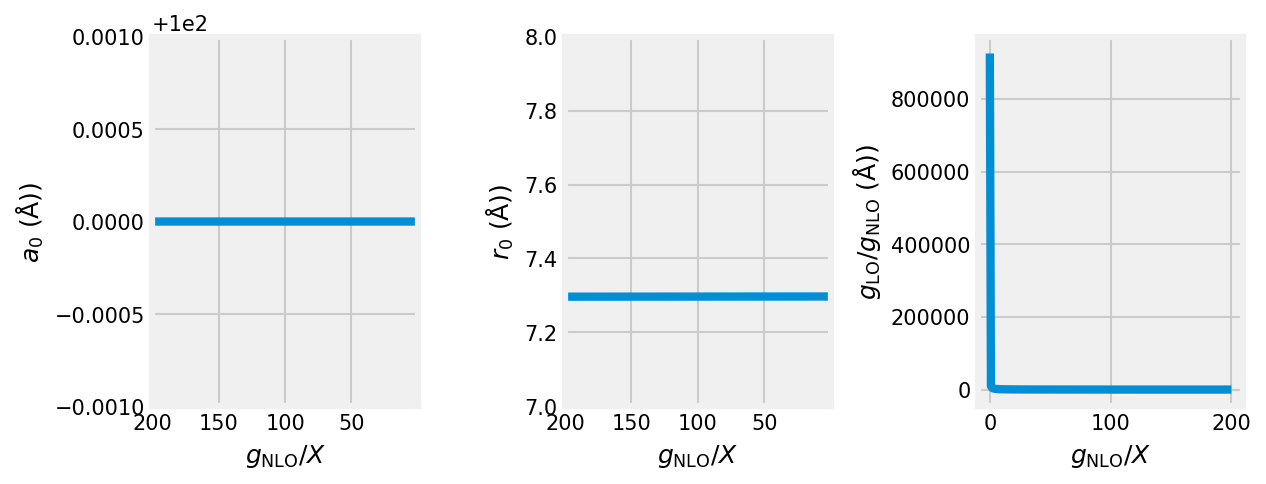

In [360]:
fig, ax = plt.subplots(1, 3, figsize=(2*gr*h, h), dpi=150)
fig.patch.set_facecolor('white')
fig.tight_layout(w_pad=4)
ax[0].plot(g_nlo_test/X, test_results[:, 0])
ax[1].plot(g_nlo_test/X, test_results[:, 1])
ax[2].plot(g_nlo_test/X,glo_refit/g_nlo_test)

ax[0].set_ylim(99.999,100.001)

ax[0].set_xlabel(r'$g_{\rm NLO}/X$')
ax[0].set_ylabel(r'$a_0$ (Å))')
ax[0].set_xlim(xlo,xhi)

ax[1].set_xlabel(r'$g_{\rm NLO}/X$')
ax[1].set_ylabel(r'$r_0$ (Å))');
ax[1].set_xlim(xlo,xhi)
ax[1].set_ylim(7,8)


ax[2].set_ylabel(r'$g_{\rm LO}/g_{\rm NLO}$ (Å))');
ax[2].set_xlabel(r'$g_{\rm NLO}/X$')

In [351]:
N = 30
test_results[N]

array([100.        ,   7.29713325])

In [357]:
N = 100
test_results[N]

array([100.        ,   7.29695639])

In [348]:
print(glo_refit[N], " ",g_nlo_test[N])

612739.5396936117   1954.956025464964


In [362]:
he4.BETA6/R

4.938775510204082

In [255]:
phshift = s.phase_shifts(330671.13967153005,-18177.707019376576,momenta)

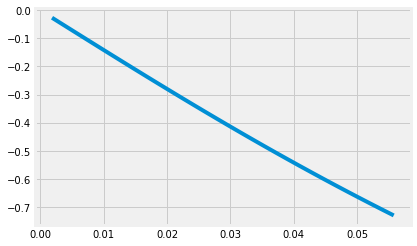

In [257]:
plt.plot(momenta,phshift)

In [240]:
np.savetxt(f'gLO_gNLO_R_{R}.dat', np.vstack((glo_refit, g_nlo_test, test_results.T)).T)

## Changed C6 value

In [596]:
len(Rs_plus)

50

In [597]:
NR = 19
R=Rs_plus[NR]
print(R)
s = he4plus.Helium4System(R, ELL)

1.280760613207547


In [ ]:
xhi =-0.1
xlo=-340.
#xhi=0.01
g_nlo_test = np.linspace(xhi, xlo, 450)*X
test_results = []
glo_refit = []
guess = lo_plus_gs[NR]

for gj in g_nlo_test:
    result = optimize.fsolve(a0_diff, guess, args=(gj, s),xtol=1e-14)
    test_results.append(s.a0_and_r0(result[0], gj, momenta, use_c=True))
    glo_refit.append(result[0])
    guess = result[0]

/opt/local/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [ ]:
def fitloop(gnlotest_array_new, gnlotest_array_old,test_results, glo_refit, lo_gs, nR):
    if type(test_results) != list:
        test_results = test_results.tolist()
    if len(glo_refit) == 0 :
        guess = lo_gs[NR]
    else:
        guess = glo_refit[-1]
    for gj in gnlotest_array_new:
        
        result = optimize.fsolve(a0_diff, guess, args=(gj, s),xtol=1e-14)
        test_results.append(s.a0_and_r0(result[0], gj, momenta, use_c=True))
        glo_refit.append(result[0])
        guess = result[0]
    gnlotest_array_old = np.hstack((gnlotest_array_old,gnlotest_array_new))
    print(len(gnlotest_array_old))

In [120]:
#gnlotest_array_new = np.linspace(2, 4, 2)
#np.append(gnlotest_array_new,4)
#fitloop(gnlotest_array_new, g_nlo_test, test_results,glo_refit,lo_plus_gs,1)

/opt/local/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


4


/opt/local/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)


In [568]:
test_results
test_results = np.array(test_results)

Text(0.5, 20.625, '$g_{\\rm NLO}/X$')

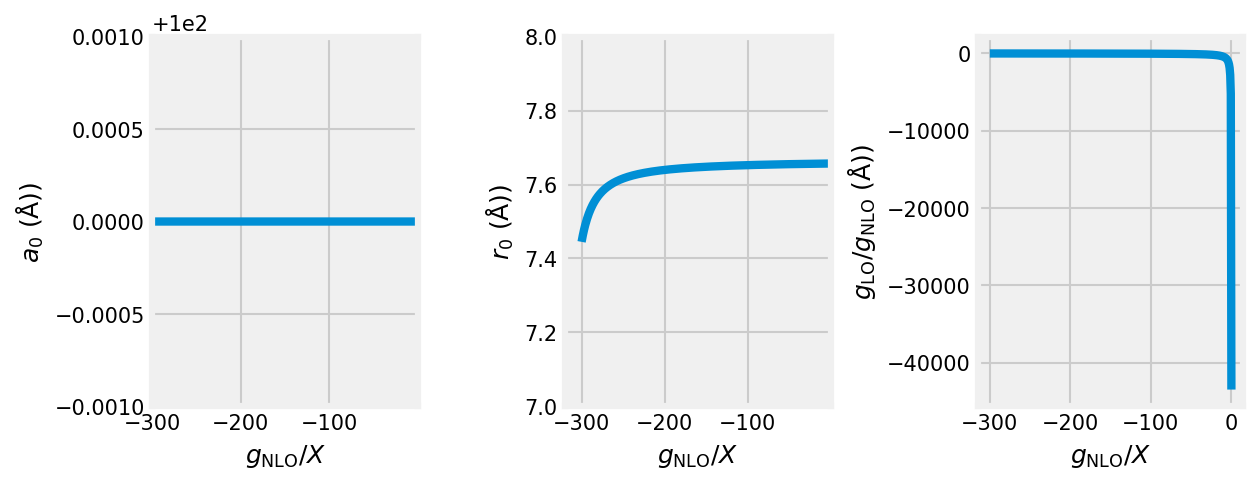

In [570]:
fig, ax = plt.subplots(1, 3, figsize=(2*gr*h, h), dpi=150)
fig.patch.set_facecolor('white')
fig.tight_layout(w_pad=4)
ax[0].plot(g_nlo_test/X, test_results[:, 0])
ax[1].plot(g_nlo_test/X, test_results[:, 1])
ax[2].plot(g_nlo_test/X,glo_refit/g_nlo_test)

ax[0].set_ylim(99.999,100.001)

ax[0].set_xlabel(r'$g_{\rm NLO}/X$')
ax[0].set_ylabel(r'$a_0$ (Å))')
ax[0].set_xlim(xlo,xhi)

ax[1].set_xlabel(r'$g_{\rm NLO}/X$')
ax[1].set_ylabel(r'$r_0$ (Å))');
ax[1].set_xlim(xlo,xhi)
ax[1].set_ylim(7,8.)
ax[1].set_xlim(-320,-0.1)


ax[2].set_ylabel(r'$g_{\rm LO}/g_{\rm NLO}$ (Å))');
ax[2].set_xlabel(r'$g_{\rm NLO}/X$')

In [571]:
test_results[409,:]

array([100.        ,   7.44502419])

In [559]:
g_nlo_test[377]

-18150.004313041925

In [560]:
glo_refit[377]

313141.58632874576

In [563]:
he4.BETA6/R

3.9606374540650604

In [561]:
R

1.35760625

In [203]:
ii = np.where(test_results[:, 0] > 99.9995)[0]
test_results[ii, :].T

array([[100.        , 100.        , 100.        , ..., 100.00000036,
        100.        , 100.00000758],
       [  7.76290059,   7.76208853,   7.761253  , ...,   7.82047651,
          7.82047499,   7.8204786 ]])

In [572]:
glo_refit_ndarray = np.array(glo_refit)
plus_results = np.vstack((glo_refit_ndarray, g_nlo_test,test_results.T)).T

(-200.0, 0.0)

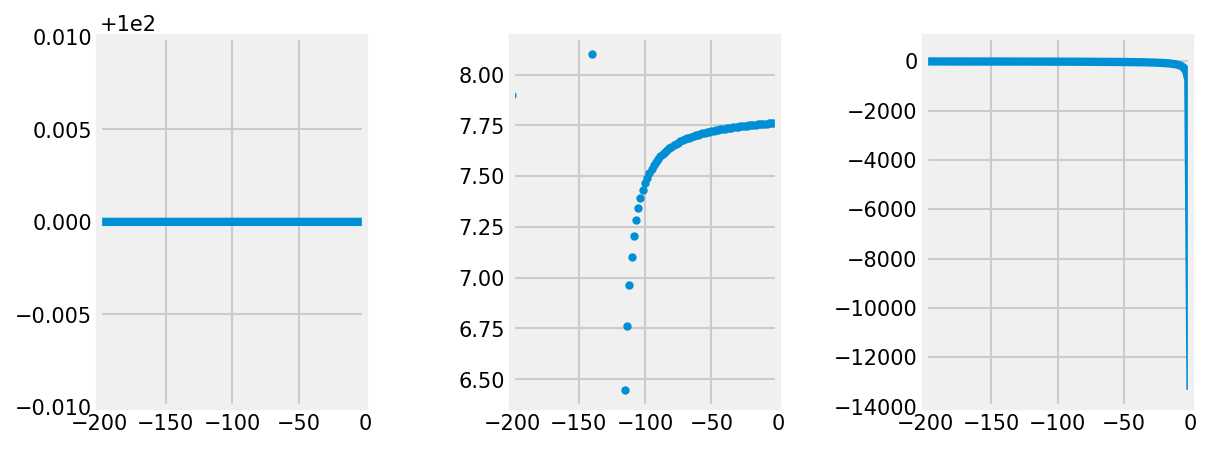

In [241]:
fig, ax = plt.subplots(1, 3, figsize=(2*gr*h, h), dpi=150)
fig.patch.set_facecolor('white')
fig.tight_layout(w_pad=4)
ax[0].plot(plus_results[:,1]/X, plus_results[:, 2])
ax[0].set_ylim(99.99,100.01)
ax[0].set_xlim(-200,0)
ax[1].plot(plus_results[:,1]/X, plus_results[:, 3],'.')
ax[1].set_xlim(-200,0)
ax[2].plot(plus_results[:,1]/X,plus_results[:,0]/plus_results[:,1])
ax[2].set_xlim(-200,0)

In [565]:
np.savetxt(f'gLO_gNLO_plus_R_{R}.dat', plus_results)

In [279]:
 plus_results[0,:]

array([ 8.68467000e+04, -6.51652008e+00,  1.00000000e+02,  7.76290059e+00])

In [387]:
 plus_results[196,:]

array([ 1.36837308e+05, -7.70203555e+03,  1.00000000e+02,  7.31865919e+00])

In [388]:
 plus_results[195,:]

array([ 1.36769561e+05, -7.66277269e+03,  1.00000000e+02,  7.33633561e+00])

In [574]:
g_nlo_refined = np.linspace(plus_results[409,1],plus_results[315,1],10)[1:-1]
g_nlo_refined = np.linspace(plus_results[409,1],-320*X,20)[1:-1]
g_nlo_refined

array([-19618.15520291, -19686.75015117, -19755.34509944, -19823.9400477 ,
       -19892.53499596, -19961.12994422, -20029.72489248, -20098.31984075,
       -20166.91478901, -20235.50973727, -20304.10468553, -20372.69963379,
       -20441.29458205, -20509.88953032, -20578.48447858, -20647.07942684,
       -20715.6743751 , -20784.26932336])

In [577]:
plus_results_refined = plus_results[0:410,:]

In [467]:
R

1.5427343749999998

In [578]:
guess = plus_results_refined[409,0]

for gj in g_nlo_refined:
    print(gj)
    glo_temp = optimize.fsolve(a0_diff, guess, args=(gj, s),xtol=1e-14)[0]
    atemp, rtemp = s.a0_and_r0(glo_temp, gj, momenta, use_c=True)
    plus_results_refined = np.vstack((plus_results_refined,np.array([glo_temp, gj, atemp, rtemp])))
    guess = glo_temp

-19618.155202911566
-19686.750151173495
-19755.345099435424
-19823.940047697353
-19892.53499595928
-19961.129944221208
-20029.724892483137
-20098.319840745065
-20166.914789006994
-20235.509737268923
-20304.104685530852
-20372.69963379278
-20441.29458205471
-20509.88953031664
-20578.484478578564
-20647.079426840493
-20715.674375102422
-20784.26932336435


In [345]:
he4.R0

7.33

In [592]:
he4.BETA6/R

4.0794565776870115

In [539]:
plus_results_total[316,0]

7.333089360056134

In [579]:
plus_results_total=np.vstack((plus_results_refined,plus_results[315:len(plus_results),:]))
plus_results_total=plus_results_refined

In [591]:
plus_results_total[415,1]

-19961.129944221208

(-200.0, 0.0)

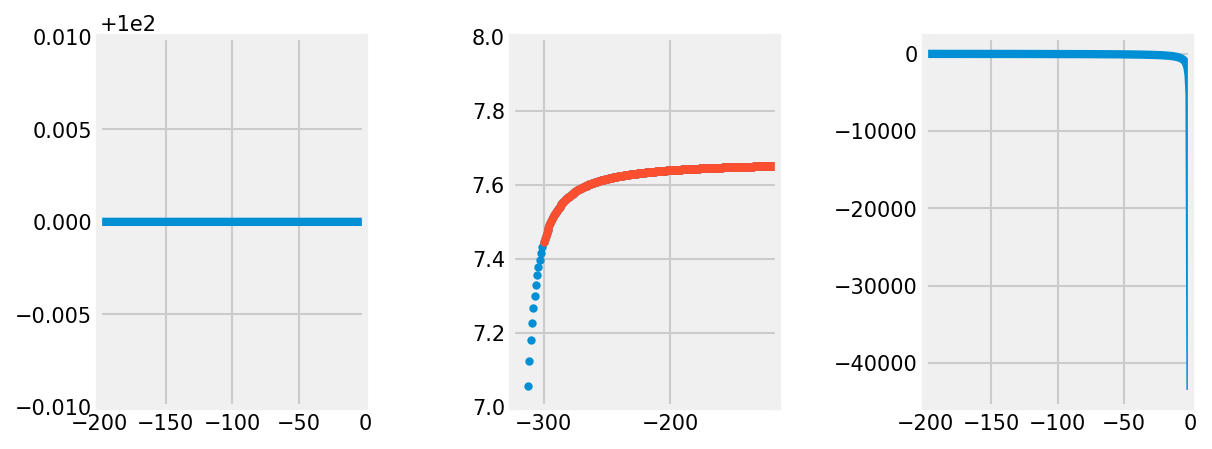

In [583]:
fig, ax = plt.subplots(1, 3, figsize=(2*gr*h, h), dpi=150)
fig.patch.set_facecolor('white')
fig.tight_layout(w_pad=4)
ax[0].plot(plus_results_total[:,1]/X, plus_results_total[:, 2])
ax[0].set_ylim(99.99,100.01)
ax[0].set_xlim(-200,0)
ax[1].plot(plus_results_total[:,1]/X, plus_results_total[:, 3],'.')
ax[1].plot(plus_results[:,1]/X, plus_results[:, 3],'.')
ax[1].set_xlim(-325,-115)
ax[1].set_ylim(7,8)
ax[2].plot(plus_results[:,1]/X,plus_results[:,0]/plus_results[:,1])
ax[2].set_xlim(-200,0)

In [317]:
len(plus_results)

5880

### Small R

In [198]:
N = 170
s.a0_and_r0(glo_refit[N], g_nlo_test[N], momenta, use_c=True)

(100.00000000085701, 7.334908117157197)

I will say that small R is the domain in which the effective range is smaller than the LM2M2 result. Here we need to move towards positive g.

In [261]:
xlo= 100
xhi= 0.01
g_nlo_test = np.linspace(xhi, xlo, 90)*X
test_results = []
glo_refit = []
guess = lo_gs[NR]

for gj in g_nlo_test:
    result = optimize.fsolve(a0_diff, guess, args=(gj, s),xtol=1e-14)
    test_results.append(s.a0_and_r0(result[0], gj, momenta, use_c=True))
    glo_refit.append(result[0])
    guess = result[0]


In [262]:
test_results
test_results = np.array(test_results)

Text(0.5, 20.625, '$g_{\\rm NLO}/X$')

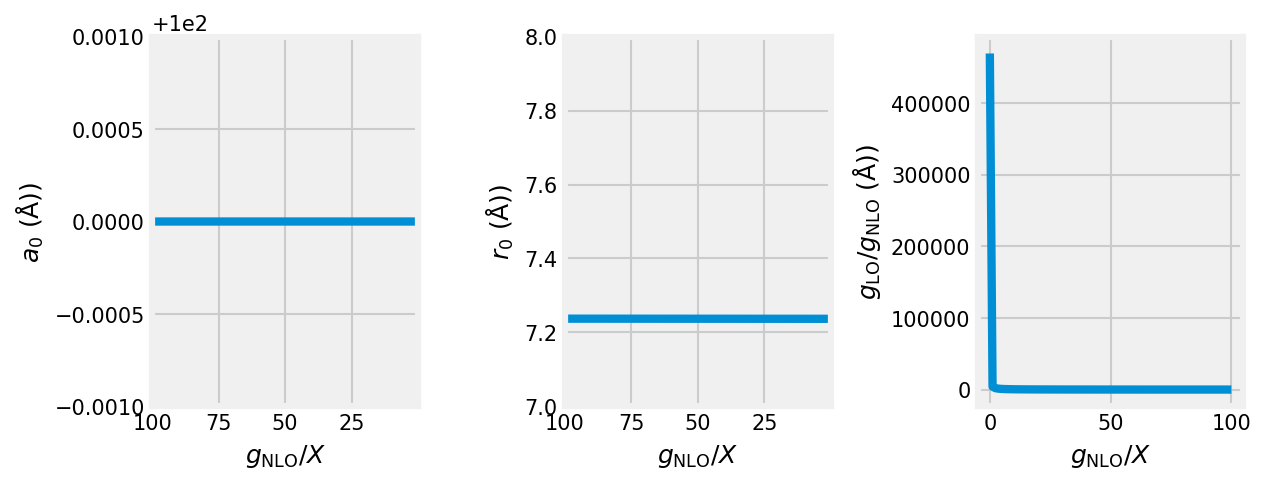

In [263]:
fig, ax = plt.subplots(1, 3, figsize=(2*gr*h, h), dpi=150)
fig.patch.set_facecolor('white')
fig.tight_layout(w_pad=4)
ax[0].plot(g_nlo_test/X, test_results[:, 0])
ax[1].plot(g_nlo_test/X, test_results[:, 1])
ax[2].plot(g_nlo_test/X,glo_refit/g_nlo_test)

ax[0].set_ylim(99.999,100.001)

ax[0].set_xlabel(r'$g_{\rm NLO}/X$')
ax[0].set_ylabel(r'$a_0$ (Å))')
ax[0].set_xlim(xlo,xhi)

ax[1].set_xlabel(r'$g_{\rm NLO}/X$')
ax[1].set_ylabel(r'$r_0$ (Å))');
ax[1].set_xlim(xlo,xhi)
ax[1].set_ylim(7,8)


ax[2].set_ylabel(r'$g_{\rm LO}/g_{\rm NLO}$ (Å))');
ax[2].set_xlabel(r'$g_{\rm NLO}/X$')

In [9]:
for i in range(nR):
    R = Rs[i]
    s = he4.construct_helium4_system(R, ELL)
    result = optimize.minimize(kcd_diff, guess, args=(s))
    gs = result.x
    a0, r0 = s.a0_and_r0(*gs, momenta)
    
    if np.abs((he4.A0 - a0)/he4.A0) < 1e-2 and np.abs((he4.R0 - r0)/he4.R0) < 1e-2:
        e2s = s.bound_state_spectrum(*gs)
        g_los[i] = gs[0]
        g_nlos[i] = gs[1]
        b2s[i] = np.abs(e2s[0])
        print(f'i = {i}  R = {R}  g = {g/X:.4e} X  a0 = {a0:.4e}  r0 = {r0:.4e}  b2 = {np.abs(e2s[0])}')
        guess = gs
    else:
        break

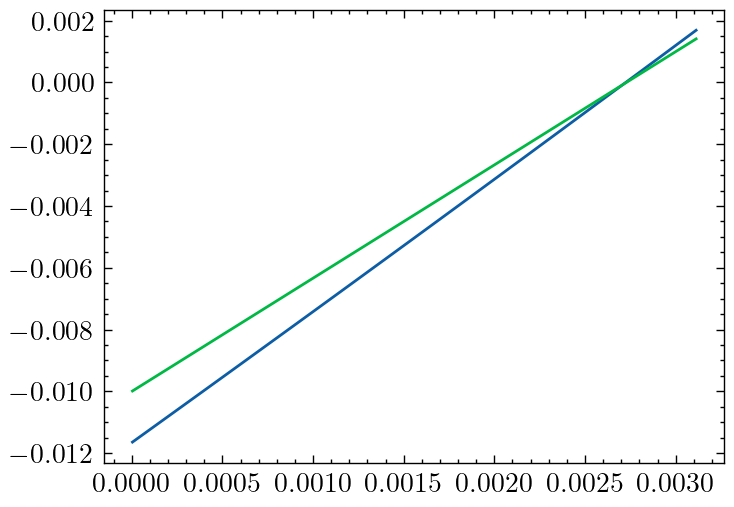

In [12]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(momenta**2, s.kcotd_gen_fast(momenta, *gs))
ax.plot(momenta**2, KCD);

In [7]:
restart = 2
s = he4.construct_helium4_system(Rs[restart], ELL)

In [8]:
guess = -2200*X
inverse_a0_diff(guess, s)

0.011628295276288475

In [9]:
for i in range(restart, nR):
    R = Rs[i]
    s = he4.construct_helium4_system(R, ELL)
    result = optimize.fsolve(inverse_a0_diff, guess, args=(s), factor=0.1)
    g = result[0]
    a0, r0 = s.a0_and_r0(g, 0, momenta)
    
    if np.abs((he4.A0 - a0)/he4.A0) < 1e-4:
        e2s = s.bound_state_spectrum(g, 0)
        gs[i] = g
        r0s[i] = r0
        b2s[i] = np.abs(e2s[0])
        print(f'i = {i}  R = {R}  g = {g/X:.4e} X  a0 = {a0:.4e}  r0 = {r0:.4e}  b2 = {np.abs(e2s[0])}')
    else:
        break

i = 2  R = 2.3952029265410713  g = -2.1799e+03 X  a0 = 1.0000e+02  r0 = 7.9727e+00  b2 = 0.0013214408847803851
i = 3  R = 2.2713131199958436  g = 1.3034e+02 X  a0 = 1.0000e+02  r0 = 7.8292e+00  b2 = 0.0013191038331283743
i = 4  R = 2.1596091960616217  g = 4.8941e+02 X  a0 = 1.0000e+02  r0 = 7.7232e+00  b2 = 0.0013173873169407763
i = 5  R = 2.0583775149962333  g = 7.1346e+02 X  a0 = 1.0000e+02  r0 = 7.6482e+00  b2 = 0.0013161765744706488
i = 6  R = 1.9662113576083418  g = 9.0763e+02 X  a0 = 1.0000e+02  r0 = 7.5979e+00  b2 = 0.0013153667611003478
i = 7  R = 1.8819451565679846  g = 1.0975e+03 X  a0 = 1.0000e+02  r0 = 7.5666e+00  b2 = 0.0013148625513397642
i = 8  R = 1.8046049446542318  g = 1.2927e+03 X  a0 = 1.0000e+02  r0 = 7.5490e+00  b2 = 0.0013145783506912495
i = 9  R = 1.7333705389441965  g = 1.4981e+03 X  a0 = 1.0000e+02  r0 = 7.5403e+00  b2 = 0.0013144388604214492
i = 10  R = 1.6675463412627713  g = 1.7169e+03 X  a0 = 1.0000e+02  r0 = 7.5367e+00  b2 = 0.0013143801973354624
i = 11  

In [10]:
restart = 20
s = he4.construct_helium4_system(Rs[restart], ELL)

In [25]:
guess = 5200*X
inverse_a0_diff(guess, s)

0.01756929408829582

In [27]:
for i in range(restart, nR):
    R = Rs[i]
    s = he4.construct_helium4_system(R, ELL)
    result = optimize.fsolve(inverse_a0_diff, guess, args=(s), factor=0.1)
    g = result[0]
    a0, r0 = s.a0_and_r0(g, 0, momenta)
    
    if np.abs((he4.A0 - a0)/he4.A0) < 1e-4:
        e2s = s.bound_state_spectrum(g, 0)
        gs[i] = g
        r0s[i] = r0
        b2s[i] = np.abs(e2s[0])
        print(f'i = {i}  R = {R}  g = {g/X:.4e} X  a0 = {a0:.4e}  r0 = {r0:.4e}  b2 = {np.abs(e2s[0])}')
        guess = g
    else:
        break

i = 20  R = 1.2085886326583386  g = 5.2006e+03 X  a0 = 1.0000e+02  r0 = 7.3942e+00  b2 = 0.0013121079582042146
i = 21  R = 1.1762157228549903  g = 5.8092e+03 X  a0 = 1.0000e+02  r0 = 7.3681e+00  b2 = 0.0013116937950748658
i = 22  R = 1.1455318344326864  g = 6.5581e+03 X  a0 = 1.0000e+02  r0 = 7.3427e+00  b2 = 0.0013112929731866894
i = 23  R = 1.1164081437267706  g = 7.5732e+03 X  a0 = 1.0000e+02  r0 = 7.3189e+00  b2 = 0.001310916807813701
i = 24  R = 1.0887286029732142  g = 9.2501e+03 X  a0 = 1.0000e+02  r0 = 7.2972e+00  b2 = 0.00131057412079892
i = 25  R = 1.0623883948367656  g = 1.3829e+04 X  a0 = 1.0000e+02  r0 = 7.2780e+00  b2 = 0.0013102710635809318


In [28]:
restart = 26
s = he4.construct_helium4_system(Rs[restart], ELL)

In [38]:
guess = -40000*X
inverse_a0_diff(guess, s)

0.014427023535276869

In [39]:
for i in range(restart, nR):
    R = Rs[i]
    s = he4.construct_helium4_system(R, ELL)
    result = optimize.fsolve(inverse_a0_diff, guess, args=(s), factor=0.1)
    g = result[0]
    a0, r0 = s.a0_and_r0(g, 0, momenta)
    
    if np.abs((he4.A0 - a0)/he4.A0) < 1e-4:
        e2s = s.bound_state_spectrum(g, 0)
        gs[i] = g
        r0s[i] = r0
        b2s[i] = np.abs(e2s[0])
        print(f'i = {i}  R = {R}  g = {g/X:.4e} X  a0 = {a0:.4e}  r0 = {r0:.4e}  b2 = {np.abs(e2s[0])}')
        guess = g
    else:
        break

i = 26  R = 1.0372926059823537  g = -3.8923e+04 X  a0 = 1.0000e+02  r0 = 7.2615e+00  b2 = 0.0013100111334430663
i = 27  R = 1.0133550843058379  g = 1.4832e+03 X  a0 = 1.0000e+02  r0 = 7.2478e+00  b2 = 0.0013097954390147329
i = 28  R = 0.9904974508252551  g = 4.6927e+03 X  a0 = 1.0000e+02  r0 = 7.2369e+00  b2 = 0.0013096229901129013
i = 29  R = 0.9686482423511685  g = 6.2308e+03 X  a0 = 1.0000e+02  r0 = 7.2285e+00  b2 = 0.001309491010550352
i = 30  R = 0.9477421651781218  g = 7.3277e+03 X  a0 = 1.0000e+02  r0 = 7.2224e+00  b2 = 0.001309395414593954
i = 31  R = 0.9277194433785839  g = 8.2575e+03 X  a0 = 1.0000e+02  r0 = 7.2183e+00  b2 = 0.0013093311560888024
i = 32  R = 0.9085252479983373  g = 9.1166e+03 X  a0 = 1.0000e+02  r0 = 7.2159e+00  b2 = 0.0013092925929792864
i = 33  R = 0.8901091956740469  g = 9.9480e+03 X  a0 = 1.0000e+02  r0 = 7.2147e+00  b2 = 0.001309273863222863
i = 34  R = 0.872424907018271  g = 1.0774e+04 X  a0 = 1.0000e+02  r0 = 7.2144e+00  b2 = 0.0013092691650489956
i = 

In [40]:
import matplotlib.pyplot as plt

plt.style.use('science')
gr = 4/3
h = 3

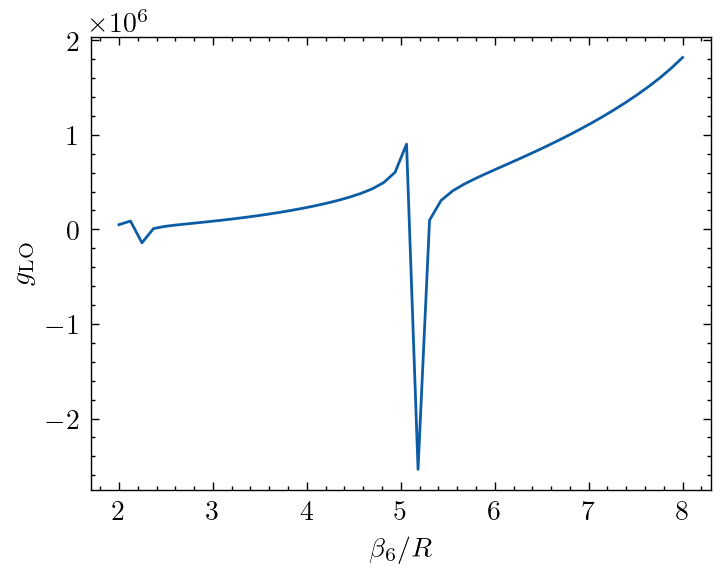

In [51]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(he4.BETA6/Rs, gs)

ax.set_xlabel(r'$\beta_6/R$')
ax.set_ylabel(r'$g_{\rm LO}$');

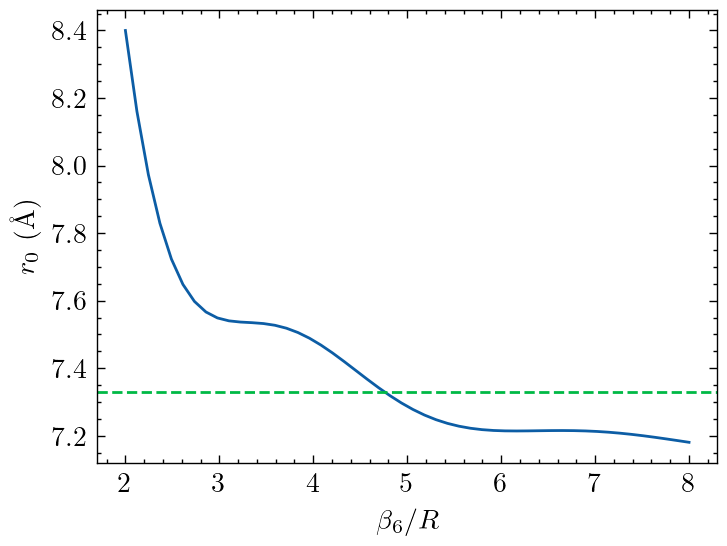

In [52]:
fig, ax = plt.subplots(figsize=(gr*h, h), dpi=200)
fig.patch.set_facecolor('white')

ax.plot(he4.BETA6/Rs, r0s)
ax.axhline(he4.R0, color='C1', linestyle='--')

ax.set_xlabel(r'$\beta_6/R$')
ax.set_ylabel(r'$r_0$ (Å)');

In [53]:
np.savetxt('datfiles/he4_LO_nonlocal_rg_flow.txt', np.vstack((Rs, gs)).T, header='R (Å)  g ()')

In [54]:
np.savetxt('datfiles/he4_LO_nonloca_r0s.txt', np.vstack((Rs, r0s)).T, header='R (Å)  r_0 (Å)')